# 🔁 What is Iterative Retrieval in Agentic RAG?
Combined both Iterative And Self reflection

✅ Definition:
Iterative Retrieval is a dynamic strategy where an AI agent doesn't settle for the first batch of retrieved documents. Instead, it evaluates the adequacy of the initial context, and if necessary, it:

- Refines the query,
- Retrieves again,
- Repeats the process until it’s confident enough to answer the original question.

🧠 Why Use It?

In standard RAG:

- A single retrieval step is done, and the LLM uses it to answer.
- If the documents were incomplete or irrelevant, the answer may fail.

In Iterative RAG:

- The agent reflects on the retrieved content and the answer it produced.
- If it’s unsure, it can refine its search (like a human researcher would).

## Setup and Import Libraries

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o")

## Load and Embed Documents

In [5]:
documents = TextLoader("internal_docs.txt", encoding="utf-8").load()

chunks = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50
).split_documents(documents=documents)

In [6]:
vector_store = FAISS.from_documents(
    documents=chunks, embedding=embeddings)

retriever = vector_store.as_retriever()

## Define Agent State

In [7]:
class IterativeRAGState(BaseModel):
    question: str
    refined_question: str = ""
    retrieved_documents: List[Document] = []
    answer: str = ""
    verified: bool = False
    attempts: int = 0

## Nodes

### Retrieve Node

In [8]:
def retrieve_documents(state: IterativeRAGState) -> IterativeRAGState:
    query = state.refined_question or state.question
    documents = retriever.invoke(query)
    
    return state.model_copy(update={"retrieved_documents": documents})

### Reflect And Verify Node

In [9]:
def generate_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    context = "\n\n".join(doc.page_content for doc in state.retrieved_documents)
    prompt = f"""
    Use the following context to answer the question:

    Context:
    {context}

    Question:
    {state.question}
    """

    response = llm.invoke(input=prompt.strip()).content.strip()
    
    return state.model_copy(update={"answer": response, "attempts": state.attempts + 1})

### Reflect Node

In [10]:
def reflect_on_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
    Evaluate whether the answer below is factually sufficient and complete.

    Question: {state.question}
    Answer: {state.answer}

    Respond 'YES' if it's complete, otherwise 'NO' with feedback.
    """

    feedback = llm.invoke(input=prompt).content.lower()
    verified = "yes" in feedback

    return state.model_copy(update={"verified": verified})

### Refine Query Node

In [11]:
def refine_query(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
    The answer appears incomplete. Suggest a better version of the query that would help retrieve more relevant context.

    Original Question: {state.question}
    Current Answer: {state.answer}
    """

    new_query = llm.invoke(input=prompt).content.strip()
    
    return state.model_copy(update={"refined_question": new_query})

## Build Graph

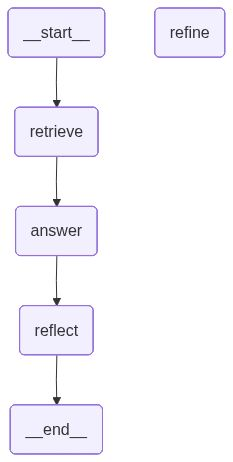

In [12]:
builder = StateGraph(IterativeRAGState)

# Add Nodes
builder.add_node(node="retrieve", action=retrieve_documents)
builder.add_node(node="answer", action=generate_answer)
builder.add_node(node="reflect", action=reflect_on_answer)
builder.add_node(node="refine", action=refine_query)

# Set Entry Point
builder.set_entry_point(key="retrieve")

# Add Edges
builder.add_edge(start_key="retrieve", end_key="answer")
builder.add_edge(start_key="answer", end_key="reflect")
builder.add_conditional_edges(
    "reflect",
    lambda s: END if s.verified or s.attempts >= 2 else "refine"
)
builder.add_edge(start_key="refine", end_key="retrieve")
builder.add_edge(start_key="answer", end_key=END)

# Compile Graph
graph = builder.compile()

# Display
graph

## Query

In [13]:
query = "agent loops  and transformer-based systems?"

initial_state = IterativeRAGState(question=query)
final = graph.invoke(input=initial_state)


print("✅ Final Answer:\n", final["answer"])
print("\n🧠 Verified:", final["verified"])
print("🔁 Attempts:", final["attempts"])

✅ Final Answer:
 Your question seems to be asking about the relationship or use of agent loops in transformer-based systems. Although the provided context does not explicitly mention "agent loops," it discusses various transformer models and their deployments.

Agent loops generally refer to iterative processes in autonomous systems where an agent makes decisions based on inputs, performs actions, evaluates outcomes, and refines its understanding or strategy accordingly. Transformer-based systems can be part of such agent loops, particularly in applications involving natural language processing, vision, or other AI-driven tasks.

For instance, in a chatbot system (like the one using LLAMA2 mentioned in the context), the model could be part of an agent loop where it continuously processes user inputs, generates responses, and updates its context or memory with every interaction, thus improving over time through a feedback loop. Similarly, Reformer and other transformer variants can be u

In [14]:
final

{'question': 'agent loops  and transformer-based systems?',
 'refined_question': '',
 'retrieved_documents': [Document(id='a8db37ae-5b37-4999-81f4-5a6df654148f', metadata={'source': 'internal_docs.txt'}, page_content='3. Reformer:\n    - Tested for memory efficiency on embedded devices.\n    - LSH attention led to 60% memory reduction.\n    - Integration challenges with standard transformers due to bucket collisions.\n    - Ongoing investigation for training stability and gradient clipping strategies.'),
  Document(id='1fec296f-b984-4d57-af20-2d55912bc49d', metadata={'source': 'internal_docs.txt'}, page_content='Title: Transformer Variants for Production\n\nWe have used the following transformer variants in production deployments:\n\n1. EfficientFormer:\n    - Optimized for mobile inference.\n    - Deployed in multiple mobile and edge environments.\n    - Quantized using ONNX and optimized via TensorRT.\n    - Benchmarked with 1.2ms inference time on A72 CPUs.'),
  Document(id='c990fcd